In [14]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from modelscope import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch import  nn,optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name="google-bert/bert-base-uncased"
from transformers import get_scheduler
import matplotlib.pyplot as plt

In [2]:
# 读取数据
df=pd.read_csv("cybersecurity_attacks.csv")

In [3]:
# 查看数据相关信息
print(df.columns)

df.isnull().sum().sort_values(ascending=False)

# df.describe()

Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'],
      dtype='object')


Alerts/Warnings           20067
IDS/IPS Alerts            20050
Malware Indicators        20000
Firewall Logs             19961
Proxy Information         19851
Source IP Address             0
Destination IP Address        0
Source Port                   0
Timestamp                     0
Traffic Type                  0
Packet Type                   0
Packet Length                 0
Protocol                      0
Destination Port              0
Attack Type                   0
Payload Data                  0
Anomaly Scores                0
Severity Level                0
Action Taken                  0
Attack Signature              0
User Information              0
Geo-location Data             0
Network Segment               0
Device Information            0
Log Source                    0
dtype: int64

In [4]:
# 空数据处理
df['Alerts/Warnings']=df['Alerts/Warnings'].apply(lambda x:'None' if pd.isna(x) else x)
df['IDS/IPS Alerts'] = df['IDS/IPS Alerts'].apply(lambda x: 'No Data' if pd.isna(x) else x)
df['Malware Indicators'] = df['Malware Indicators'].apply(lambda x: 'No Detection' if pd.isna(x) else x)
df['Firewall Logs'] = df['Firewall Logs'].apply(lambda x: 'No Data'if pd.isna(x) else x)
df['Proxy Information'] = df['Proxy Information'].apply(lambda x: 'No Proxy Data' if pd.isna(x) else x)

In [5]:
import re

devices = [
    r'Windows',
    r'Linux',
    r'Android',
    r'iPad',
    r'iPod',
    r'iPhone',
    r'Macintosh']


def device_os_finder(user_agent):
    for device in devices:
        match_device = re.search(device, user_agent, re.I)  # re.I makes the search case-insensitive
        if match_device:
            return match_device.group()
    return 'Unknown'

# Extract device or OS
df['Device'] = df['Device Information'].apply(device_os_finder)
df['Browser'] = df['Device Information'].str.split('/').str[0]

In [6]:
del df['Source IP Address']
del df['Destination IP Address']
del df['Timestamp']
del df['Log Source']
del df['User Information']
del df['Device Information']
del df['Geo-location Data']
df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'Network Segment',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Device',
       'Browser'],
      dtype='object')

/tmp/ipykernel_949/1142659385.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=device_counts.index, y=device_counts.values, palette='Set2')


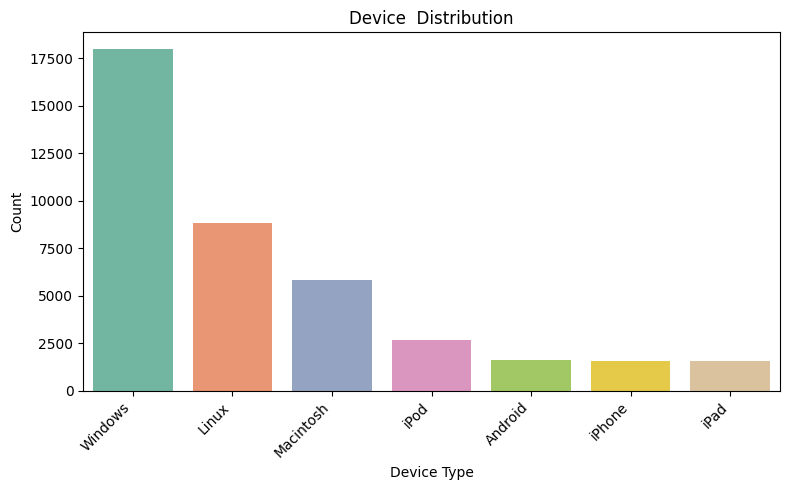

In [7]:
import seaborn as sns

# 获取设备信息的统计数量
device_counts = df['Device'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=device_counts.index, y=device_counts.values, palette='Set2')

plt.title('Device  Distribution')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

  Protocol Attack Type  COUNT
0     ICMP        DDoS   4508
6      UDP        DDoS   4482
2     ICMP     Malware   4461
1     ICMP   Intrusion   4460
3      TCP        DDoS   4438
5      TCP     Malware   4437
8      UDP     Malware   4409
7      UDP   Intrusion   4408
4      TCP   Intrusion   4397


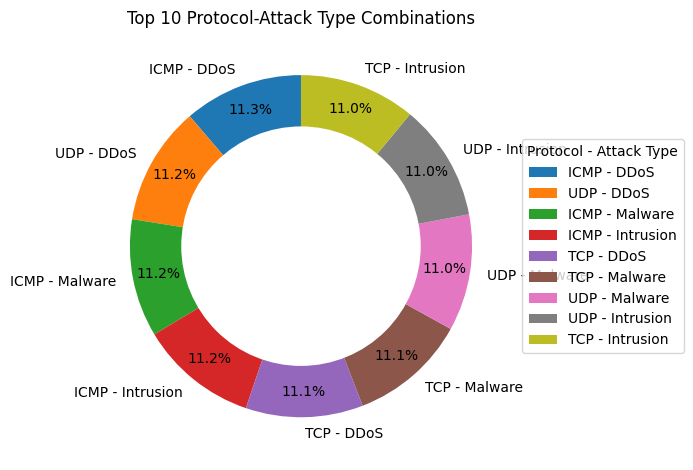

In [8]:

# Count occurrences of each combination of PROTOCOL and ATTACK TYPE
protocol_attack_counts = df.groupby(['Protocol', 'Attack Type']).size().reset_index(name='COUNT')

# Sort by count in descending order and take top 10 for better visibility
top_10 = protocol_attack_counts.sort_values('COUNT', ascending=False).head(10)

# Print a summary of the data
print(top_10)

# Create a pie chart
#ax = attack_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.plot(figsize=(12, 8))
plt.pie(top_10['COUNT'], labels=top_10.apply(lambda x: f"{x['Protocol']} - {x['Attack Type']}", axis=1), 
        autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Add a circle at the center to create a donut chart (optional)
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Add title
plt.title('Top 10 Protocol-Attack Type Combinations')

# Add legend
plt.legend(title='Protocol - Attack Type', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

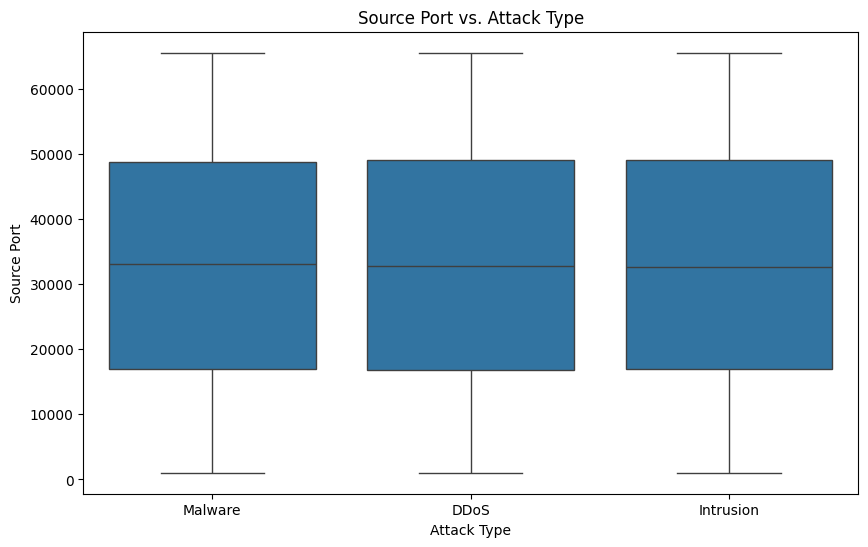

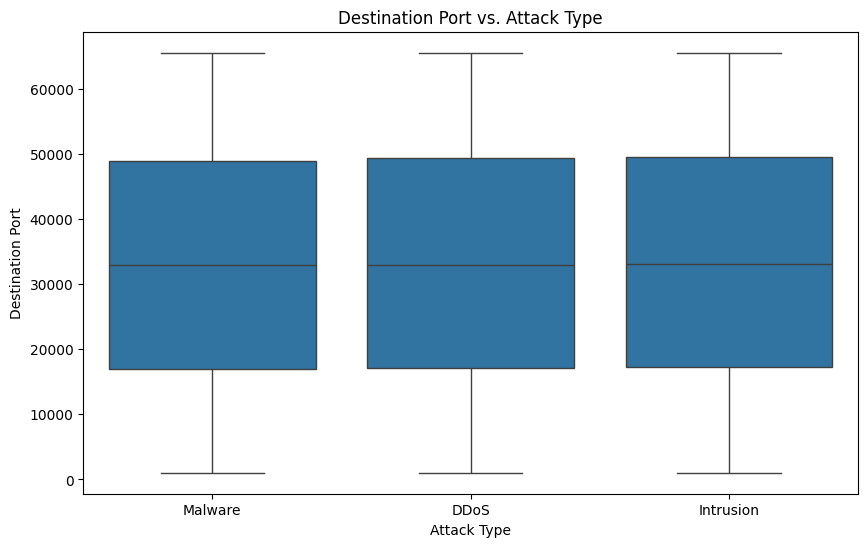

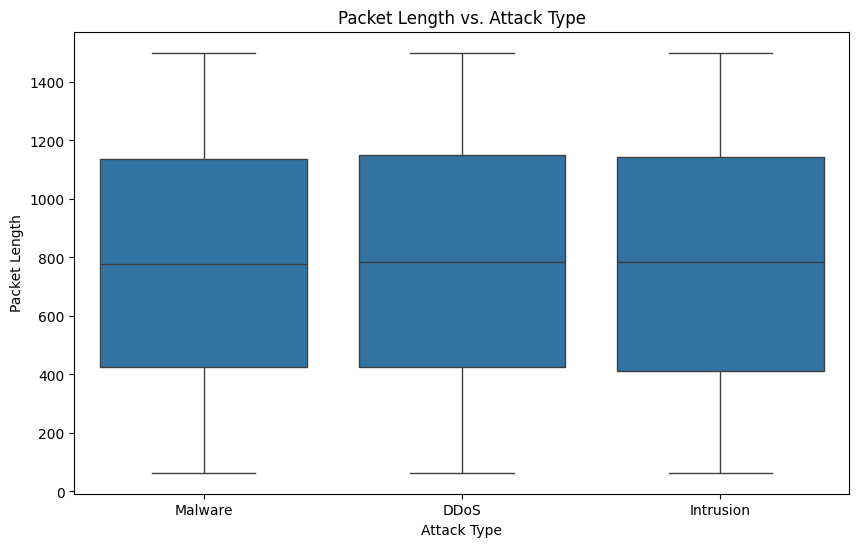

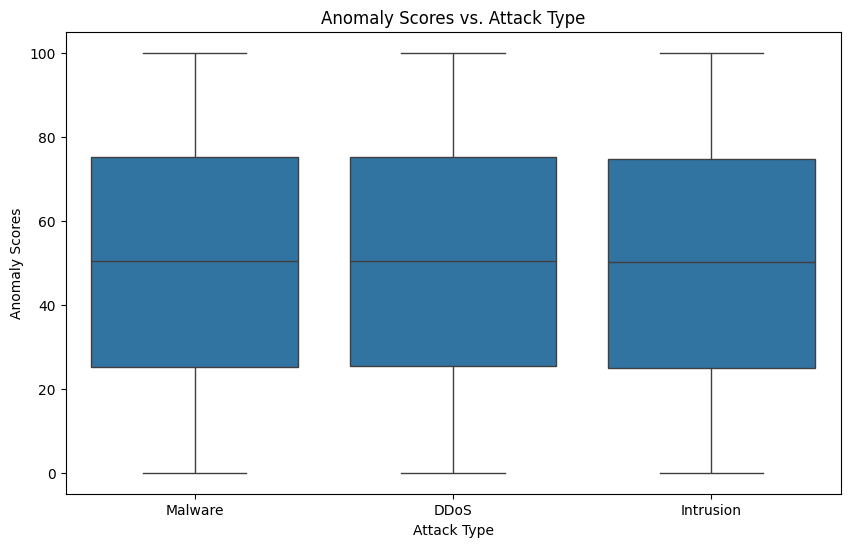

In [23]:
# Explore relationships between features and the target variable
# Select some features for visualization. Adjust based on actual features in your dataset.
features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Attack Type', y=feature, data=df)
    plt.title(f'{feature} vs. Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel(feature)
    plt.show()

In [9]:
df.columns


Index(['Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'Network Segment',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Device',
       'Browser'],
      dtype='object')

In [10]:
# 创建映射字典
label_mapping = {'Malware': 0, 'DDoS': 1, 'Intrusion': 2}

# 构建输入文本（包含所有列的数据）
texts = [
    f"Source Port: {row['Source Port']}. "
    f"Destination Port: {row['Destination Port']}. "
    f"Protocol: {row['Protocol']}. "
    f"Packet Length: {row['Packet Length']}. "
    f"Packet Type: {row['Packet Type']}. "
    f"Traffic Type: {row['Traffic Type']}. "
    f"Payload Data: {row['Payload Data']}. "
    f"Malware Indicators: {row['Malware Indicators']}. "
    f"Anomaly Scores: {row['Anomaly Scores']}. "
    f"Alerts/Warnings: {row['Alerts/Warnings']}. "
    f"Attack Signature: {row['Attack Signature']}. "
    f"Action Taken: {row['Action Taken']}. "
    f"Severity Level: {row['Severity Level']}. "
    f"Network Segment: {row['Network Segment']}. "
    f"Proxy Information: {row['Proxy Information']}. "
    f"Firewall Logs: {row['Firewall Logs']}. "
    f"IDS/IPS Alerts: {row['IDS/IPS Alerts']}. "
    f"Device: {row['Device']}. "
    f"Browser: {row['Browser']}."
    for _, row in df.iterrows()
]

# 标签
label = [label_mapping[row['Attack Type']] for _, row in df.iterrows()]


In [15]:
# 记载bert模型和分词器
bert_model = AutoModel.from_pretrained(model_name).to(device)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

2025-10-17 19:36:36.465623: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 19:36:36.737694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 19:36:37.850091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# 查看最长的token有多大
max_len = 0
for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    if len(tokens) > max_len:
        max_len = len(tokens)
print("最长的token长度为：", max_len)

最长的token长度为： 200


In [17]:
# 先划分训练集 (70%) 和临时集 (30%)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, label, test_size=0.3, random_state=42, stratify=label
)

# 再把临时集划分为验证集 (10%) 和测试集 (20%)，比例是 1:2
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=2 / 3, random_state=42, stratify=labels_temp
)

# 检查划分比例
print("训练集样本数:", len(texts_train) / 40000)
print("验证集样本数:", len(texts_val) / 40000)
print("测试集样本数:", len(texts_test) / 40000)

训练集样本数: 0.7
验证集样本数: 0.1
测试集样本数: 0.2


In [18]:



max_length = 200  # 可以根据文本长度调整


# 自定义 Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # tokenizer 编码
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )

        # 返回 dict，方便 DataLoader collate
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # [seq_len]
            'attention_mask': encoding['attention_mask'].squeeze(0),  # [seq_len]
            'labels': torch.tensor(label, dtype=torch.long)
        }


# 选择合适 batch_size（典型 BERT 是 16/32，可根据 GPU 内存调整）
batch_size = 32

# 构建 Dataset
train_dataset = TextDataset(texts_train, labels_train, bert_tokenizer, max_length)
val_dataset = TextDataset(texts_val, labels_val, bert_tokenizer, max_length)
test_dataset = TextDataset(texts_test, labels_test, bert_tokenizer, max_length)

# 构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

k = 0
# 检查第一个 batch
for batch in train_loader:
    print(batch['input_ids'].shape)  # [batch_size, max_length]
    print(batch['attention_mask'].shape)  # [batch_size, max_length]
    print(batch['labels'].shape)  # [batch_size]
    break


torch.Size([32, 200])
torch.Size([32, 200])
torch.Size([32])


In [19]:
class MyModel(nn.Module):
    def __init__(self, bert_model, num_labels=3, dropout=0.3, unfreeze_last_n=0):
        super(MyModel, self).__init__()
        self.bert = bert_model
        hidden_size = (
            self.bert.config.hidden_size if hasattr(self.bert, "config") else 768
        )

        # classifier head: 两层 + dropout + LayerNorm
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.act = nn.ReLU()
        self.norm = nn.LayerNorm(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, num_labels)

        # 默认先冻结所有 bert 参数，再按需解冻最后 n 层
        for p in self.bert.parameters():
            p.requires_grad = False
        if unfreeze_last_n > 0:

            # 适配 BertModel 的 encoder 结构
            for layer in self.bert.encoder.layer[-unfreeze_last_n:]:
                for p in layer.parameters():
                    p.requires_grad = True
            # 解冻 pooler
            if hasattr(self.bert, "pooler"):
                for p in self.bert.pooler.parameters():
                    p.requires_grad = True

    def forward(self, input_ids, attention_mask):
        # 正常前向：不再全局禁用梯度（是否真的训练 bert 由 requires_grad 控制）
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        cls_emb = outputs.pooler_output

        x = self.dropout(cls_emb)
        x = self.fc1(x)
        x = self.act(x)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
# 构建模型：示例解冻最后 2 层 bert（根据显存/数据量调整）
unfreeze_last_n = 4
my_model = MyModel(bert_model, num_labels=3, dropout=0.3, unfreeze_last_n=unfreeze_last_n).to(device)

# 不同参数组：给 bert 和 head 不同学习率
bert_lr = 2e-5
head_lr = 2e-4
bert_params = [p for n, p in my_model.named_parameters() if "bert" in n and p.requires_grad]
head_params = [p for n, p in my_model.named_parameters() if "bert" not in n and p.requires_grad]

optimizer = optim.AdamW([
    {"params": bert_params, "lr": bert_lr},
    {"params": head_params, "lr": head_lr}
])

loss_fuc = nn.CrossEntropyLoss()

num_epochs = 3
# 修正 num_training_steps：epochs * batches_per_epoch
num_training_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [28]:
from tqdm import tqdm
def train():
    my_model.train()
    best_val_acc = 0.0
    save_path = "best_model.pt"

   

    for epoch in range(num_epochs):
        
        train_loss_total = 0.0
        train_samples = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch") as pbar:
            for batch in pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                out = my_model(input_ids, attention_mask)
                loss = loss_fuc(out, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                train_loss_total += loss.item() * labels.size(0)
                train_samples += labels.size(0)

                out_label = out.argmax(dim=1)
                accuracy = (out_label == labels).sum().item() / labels.size(0)
                lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.3f}", lr=f"{lr:.6f}")

        avg_train_loss = train_loss_total / train_samples
        # ------------------- 验证 -------------------
        my_model.eval()
        val_loss_total = 0.0
        val_correct = 0
        val_samples = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", unit="batch"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                out = my_model(input_ids, attention_mask)
                loss = loss_fuc(out, labels)
                val_loss_total += loss.item() * labels.size(0)

                out_label = out.argmax(dim=1)
                val_correct += (out_label == labels).sum().item()
                val_samples += labels.size(0)

        val_loss = val_loss_total / val_samples
        val_accuracy = val_correct / val_samples
        print(f"Epoch {epoch+1}: TrainLoss={avg_train_loss:.4f} ValLoss={val_loss:.4f} ValAcc={val_accuracy:.4f}")

        # 根据验证集保存最优模型（用于后续测试或调参）
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(my_model.state_dict(), save_path)
            print(f"Saved best model with val_acc={best_val_acc:.4f}")


In [29]:
# 训练模型
train()

Epoch 1/3 [Val]: 100%|██████████| 125/125 [00:17<00:00,  7.24batch/s]


Epoch 1: TrainLoss=1.1112 ValLoss=1.0988 ValAcc=0.3357
Saved best model with val_acc=0.3357


Epoch 2/3 [Val]: 100%|██████████| 125/125 [00:17<00:00,  7.31batch/s]


Epoch 2: TrainLoss=1.0997 ValLoss=1.0998 ValAcc=0.3327


Epoch 3/3 [Val]: 100%|██████████| 125/125 [00:17<00:00,  7.30batch/s]

Epoch 3: TrainLoss=1.0990 ValLoss=1.0987 ValAcc=0.3327


In [26]:
# 测试

my_model.eval()
test_correct = 0
test_samples = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", unit="batch"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = my_model(input_ids, attention_mask)
        out_label = out.argmax(dim=1)
        test_correct += (out_label == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 250/250 [00:33<00:00,  7.37batch/s]

Test Accuracy: 0.3350
